# ANN

While the ANN model can be further fine-tuned to increase its accuracy, such as increasing the number of layers and dropout, it is time-consuming and inefficient. Therefore, we focused more on other ML models.

In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from collections import defaultdict
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Import dataset 
private_data = "../datasets/cleaned/cleaned_private.csv"

df = pd.read_csv(private_data, quotechar='"', escapechar='\\', thousands=',')
df['Sale Month-Year'] = pd.to_datetime(df['Sale Date']).dt.to_period('M').astype(str)

In [3]:
def remove_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


# Apply outlier removal to Price only
for col in ['Price']:
# for col in ['Price', 'Area (SQFT)', 'Remaining Lease Years']:
    df = remove_outliers_iqr(df, col)

In [11]:
df.isna().sum()

Project Name                 0
Transacted Price ($)         0
Area (SQFT)                  0
Unit Price ($ PSF)           0
Sale Date                    0
Street Name                  0
Type of Sale                 0
Type of Area                 0
Property Type                0
Number of Units              0
Tenure                       0
Postal District              0
Market Segment               0
Floor Level                  0
x                            0
y                            0
longitude                    0
latitude                     0
Price                        0
Sale Year                    0
Lease Duration               0
Lease Start Year         22091
Remaining Lease Years        0
Distance to MRT (km)         0
Sale Month-Year              0
Lease_Category               0
dtype: int64

In [ ]:
df_features=['Area (SQFT)', 'Lease_Category', 'Property Type', 'Postal District',
            'Type of Sale', 'Floor Level', 'Sale Month-Year',  'Distance to MRT (km)']
X = df[df_features]
y = df['Price'].values

categorical_cols = ['Property Type', 'Postal District', 'Type of Sale', 'Floor Level', 'Sale Month-Year', 'Lease_Category']
numerical_cols = ['Area (SQFT)', 'Distance to MRT (km)' ]

X_encoded = pd.get_dummies(X[categorical_cols], drop_first=True)

scaler = StandardScaler()
X_numerical_scaled = scaler.fit_transform(X[numerical_cols])
X_numerical_df = pd.DataFrame(X_numerical_scaled, columns=numerical_cols)
X_final = pd.concat([X_numerical_df, X_encoded], axis=1)
X_final = pd.concat([X[numerical_cols], X_encoded], axis=1)

x_train, x_test, y_train, y_test = train_test_split(X_final, y, test_size=0.25, random_state=40)
x_train = x_train.values.astype(np.float32)
x_test = x_test.values.astype(np.float32)
x_test = x_test.astype('float32') if isinstance(x_test, pd.DataFrame) else x_test.astype('float32')
y_test = y_test.astype('float32') if isinstance(y_test, pd.DataFrame) else y_test.astype('float32')
print(x_train.shape) # split all categorical data into several columns with 1/0 for each column 
print(x_test.shape) 
print(y_train.shape)
print(y_test.shape)

(88744, 41)
(29582, 41)
(88744,)
(29582,)


Epoch 1/200
2774/2774 [==============================] - 14s 4ms/step - loss: 7974306709504.0000
Epoch 2/200
2774/2774 [==============================] - 11s 4ms/step - loss: 3807742001152.0000
Epoch 3/200
2774/2774 [==============================] - 11s 4ms/step - loss: 2851716726784.0000
Epoch 4/200
2774/2774 [==============================] - 15s 5ms/step - loss: 2777113165824.0000
Epoch 5/200
2774/2774 [==============================] - 14s 5ms/step - loss: 3047600422912.0000
Epoch 6/200
2774/2774 [==============================] - 13s 5ms/step - loss: 2311380533248.0000
Epoch 7/200
2774/2774 [==============================] - 15s 5ms/step - loss: 2068711342080.0000
Epoch 8/200
2774/2774 [==============================] - 9s 3ms/step - loss: 1952607764480.0000
Epoch 9/200
2774/2774 [==============================] - 11s 4ms/step - loss: 1543747796992.0000
Epoch 10/200
2774/2774 [==============================] - 11s 4ms/step - loss: 1871928229888.0000
Epoch 11/200
2774/2774 [======

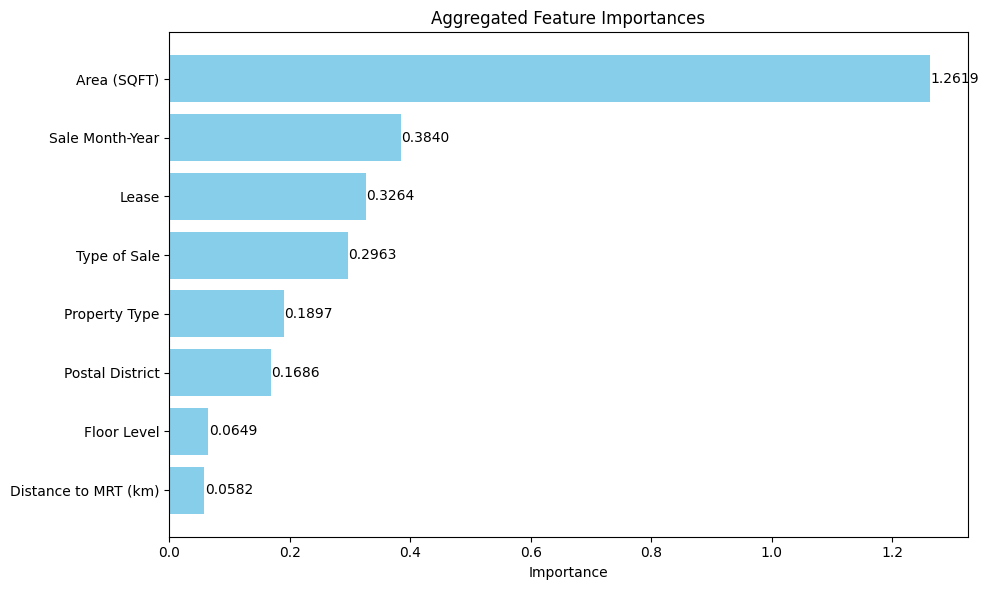

In [ ]:
# Define model builder
model=Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model_result = model.fit(x_train, y_train, epochs=200)

class KerasModelWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        pass  # already trained outside

    def predict(self, X):
        return self.model.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

wrapped_model = KerasModelWrapper(model)

# Use sklearn's permutation importance
result = permutation_importance(wrapped_model, x_test, y_test, n_repeats=10, random_state=42)

# Sort and print feature importances
sorted_idx = result.importances_mean.argsort()[::-1]

print("Feature importances (descending):\n")
feature_names = X_final.columns  

# Map each one-hot encoded column back to its base category
grouped_importances = defaultdict(float)

for i, col in enumerate(feature_names):
    # Split by underscore only if it's one-hot encoded
    if '_' in col:
        base_feature = col.split('_')[0]
    else:
        base_feature = col  # numerical feature (not one-hot encoded)
    
    grouped_importances[base_feature] += result.importances_mean[i]

# Sort and print the aggregated importances
sorted_importances = sorted(grouped_importances.items(), key=lambda x: x[1], reverse=True)

print("Aggregated Feature Importances:\n")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance:.6f}")

features, importances = zip(*sorted_importances)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.barh(features, importances, color='skyblue')
plt.xlabel("Importance")
plt.title("Aggregated Feature Importances")
plt.gca().invert_yaxis()  # Highest importance on top

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, 
        bar.get_y() + bar.get_height() / 2,
        f"{width:.4f}",
        va='center')

plt.tight_layout()
plt.show()



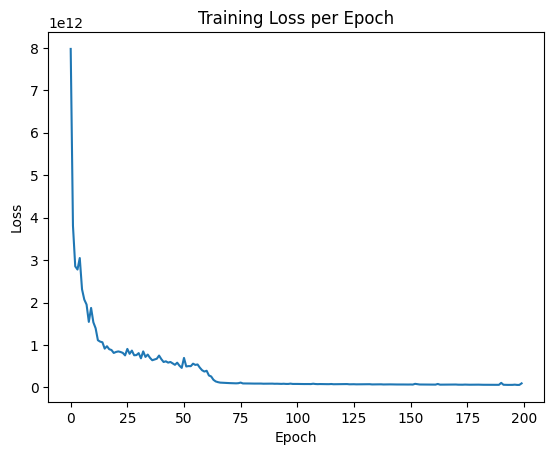

In [ ]:
# training loss
loss = model_result.history['loss']
sns.lineplot(x=range(len(loss)),y=loss)
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
test_predictions = wrapped_model.predict(x_test)
df_pred=pd.DataFrame({'test_actual': y_test})
df_pred['test_pred']=test_predictions
df_pred.head()

925/925 [==============================] - 1s 607us/step


,test_actual,test_pred
0,3675000.0,3.333120e+06
1,1447300.0,1.330068e+06
2,960000.0,1.014468e+06
3,1060000.0,1.261895e+06
4,1206000.0,1.267639e+06


925/925 [==============================] - 1s 610us/step


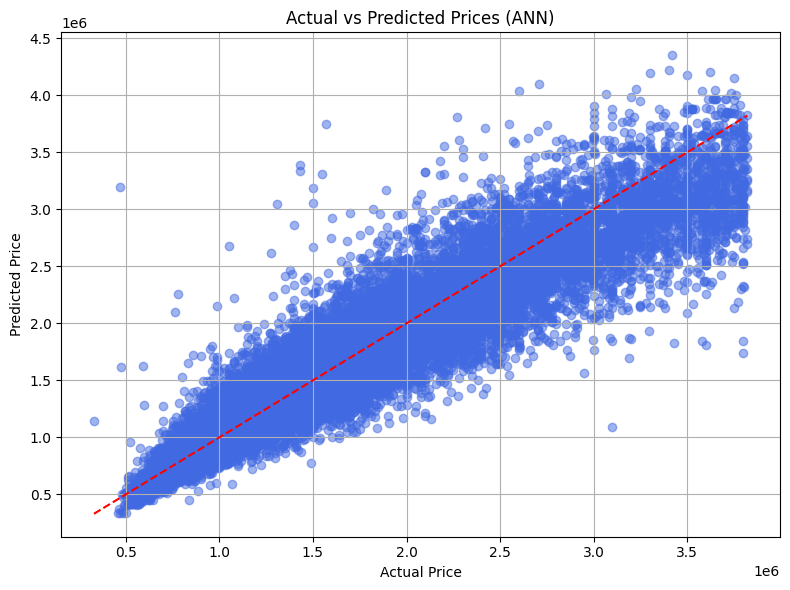

In [19]:
# Predict using the ANN model
y_pred = model.predict(x_test).flatten()

# Scatter Plot: Actual vs Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices (ANN)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
#find rmse score
mse = mean_squared_error(df_pred['test_actual'], df_pred['test_pred'])
rmse = math.sqrt(mse)
print(f"RMSE: {rmse}")

mse = mean_squared_error(df_pred['test_actual'], df_pred['test_pred'])
mae = mean_absolute_error(df_pred['test_actual'], df_pred['test_pred'])
r2 = r2_score(df_pred['test_actual'], df_pred['test_pred'])

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.4f}")

RMSE: 249481.61294973223
Mean Squared Error (MSE): 62241075200.00
Mean Absolute Error (MAE): 173008.09
R^2 Score: 0.8737
